In [4]:
%matplotlib inline

from typing import *
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import functools
import math
import random


from collections import namedtuple
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import nn, optim
import torch.nn.functional as F
import torch
import functools
import os

In [23]:
import sys
import importlib

muon_renorm = None
OPTIM_MAP = None
optims = None

def reload_module():
    global muon_renorm, OPTIM_MAP, make_model, optims

    if '241018_muon_renorm' in sys.modules:
        importlib.reload(sys.modules['241018_muon_renorm'])

    muon_renorm = __import__('241018_muon_renorm')
    OPTIM_MAP = muon_renorm.OPTIM_MAP

    optims = list(OPTIM_MAP.keys())

reload_module()

In [115]:
model = muon_renorm.make_model()

In [133]:
model.to(torch.bfloat16)
muon_renorm.orth_init(model)

for p in model.parameters():
    p.requires_grad_(True)

# for p in model.parameters():
#     p.requires_grad_(False)


steps = []
losses = []
grads = []
momentums = []
updates = []
rawgnorms = []
gnorms = []
target_norms = []

param_fn = lambda model: model._orig_mod[4].weight
param_fn = lambda model: model._orig_mod[0].weight
param_fn = lambda model: model._orig_mod[2].weight

param_fn(model).requires_grad_(True)

pre_broken_sd = None
broken_sd = None
data_target = None

def callback(step, model, optimizers, data, target, loss):
    global grokked, pre_broken_sd, broken_sd, data_target
    data_target = data, target
    if broken_sd is None and False:
        with torch.no_grad():
            post_step_loss = F.cross_entropy(model(data.flatten(1)), target).item()
        if loss.item() < 1e-2 and post_step_loss > 0.05:
            broken_sd = {k: v.data.clone() for k, v in model.state_dict().items()}
            print(f'broken at step {step}, loss: {loss.item():.4f}, post_step_loss: {post_step_loss:.4f}')
        else:
            pre_broken_sd = {k: v.data.clone() for k, v in model.state_dict().items()}
            # import ipdb; ipdb.set_trace()
    # if step in [100]:
    #     for pg in optimizers[0].param_groups:
    #         for p in pg['params']:
    #             if 'momentum_buffer' in optimizers[0].state[p]:
    #                 optimizers[0].state[p]['momentum_buffer'].zero_()
    # if step == 100:
    #     for pg in optimizers[0].param_groups:
    #         pg['nesterov'] = False
    state = optimizers[0].state[param_fn(model)]
    assert len(optimizers[0].param_groups) == 1
    group = optimizers[0].param_groups[0]

    steps.append(step)
    losses.append(loss.item())
    grads.append(param_fn(model).grad.data.clone())
    # momentums.append(state["momentum_buffer"].data.clone())
    last_update = state['last_update']
    norm_interface = muon_renorm.NormInterface(
        state,
        zeropower_backend=group['backend'],
        momentum_kind=group['momentum_kind'],
        eps=group['eps'],
        **{k: v for k, v in state['last_update'].items() if k not in {'target_norm', 'update'}},
    )

    if state.get('preconditioner') is not None and False:
        print(norm_interface.rawg.float().cpu().svd().S)
        pass
        # S = state['preconditioner'].float().svd().S
        # print(S[:5], S[-5:])
        # 1/0
        # x = muon_renorm.left_preconditioner_from_zerothpower(
        #     norm_interface.rawg / norm_interface.rawgnorm_fro,
        #     norm_interface.rawg0,
        #     dtype=torch.float64,
        #     eps=3e-3,
        # )
        # print(x)
        # print(norm_interface.rawg0.float().svd().S)
        # print(norm_interface.rawg.float().svd().S)
        # print(norm_interface.rawg.div(norm_interface.rawgnorm_fro).float().svd().S)
        # 1/0

    rawgnorms.append(norm_interface('rawg', group['norm_kind']))
    gnorms.append(norm_interface('g', group['norm_kind']))
    target_norms.append(last_update['target_norm'])
    updates.append(last_update['g'])
    if step < 100:
        do_prt = step % 10 == 0
    else:
        do_prt = step % 100 == 0
    if do_prt:
        print(f'Step {step}, Loss: {loss.item():.4f}')

muon_renorm.train_mnist(
    model,
    # opt=muon_renorm.OPTIM_MAP['muon_sign'][0],
    # opt=muon_renorm.OPTIM_MAP['muon'][0],
    # opt=muon_renorm.OPTIM_MAP['muon_post_ns'][0],
    opt=muon_renorm.OPTIM_MAP['muon_pre_ns_norm_jb_target_glbavgmomentum_dual'][0],
    # opt=muon_renorm.OPTIM_MAP['muon_post_norm_scale_nesterov_norm_jb_target_glbavggrad_dual'][0],
    # opt=functools.partial(muon_renorm.Muon, nesterov='post_ns'),
    # opt=functools.partial(muon_renorm.Muon, norm_kind='jbnorm_exact', target_norm='rawg_dual', backend_steps=3),
    # opt=functools.partial(muon_renorm.Muon, norm_kind='jbnorm_exact', target_norm='rawg_dual',
    #                     #   momentum_kind='post_norm_scale_ema_nesterov',
    #                     #   momentum_kind='pre_ns',
    #                       backend_steps=3,
    #                       precondition_backend='newtonschulz5', precondition_backend_steps=5,
    #                       precondition_kind='min_dim', compute_precondition_freq=50, precondition_beta2=0.75,
    # ),
    # opt=functools.partial(muon_renorm.Muon, norm_kind='jbnorm_exact', target_norm='rawg_dual', momentum_kind='post_norm_scale_nesterov'),
    # opt=functools.partial(muon_renorm.Muon, norm_kind='rms_exact', target_norm='rawg'),
    nsteps=2000,
    # nsteps=15000,
    log_nsteps=100000, eval_on_log=False,
    # one_batch_overfit=True,
    batch_size=2048,
    # lr=10,
    # lr=3e-2,
    lr=5e-3,
    # lr=8e-3,
    # lr=8e-3,
    # lr=1e-3,
    # lr=1e-2,
    # lr=2e-2,
    # lr=4e-1,
    # lr=1e-1,
    # lr=2e-1,
    # lr=5e-1,
    # lr=5e-2,
    # lr=3e-4,
    # lr=8e-5,
    w_save_key=None,
    post_step_callback=callback,
    # dtype=torch.float32,
)

grads = torch.stack(grads).cuda().data.to(torch.float32)
momentums = torch.stack(momentums).cuda().data.to(torch.float32)
updates = torch.stack(updates).cuda().data.to(torch.float32)
gnorms = torch.as_tensor(gnorms).cuda().data.to(torch.float32)
target_norms = torch.as_tensor(target_norms).cuda().data.to(torch.float32)


training on cuda, torch.bfloat16
Step 10, Loss: 2.0469
Step 20, Loss: 1.2422
Step 30, Loss: 0.4844
Step 40, Loss: 0.3047
Step 50, Loss: 0.2871
Step 60, Loss: 0.2734
Step 70, Loss: 0.2012
Step 80, Loss: 0.1758
Step 90, Loss: 0.1167
Step 100, Loss: 0.1177
Step 200, Loss: 0.0737
Step 300, Loss: 0.0459
Step 400, Loss: 0.0415
Step 500, Loss: 0.0289
Step 600, Loss: 0.0265
Step 700, Loss: 0.0315
Step 800, Loss: 0.0286
Step 900, Loss: 0.0280
Step 1000, Loss: 0.0194
Step 1100, Loss: 0.0291
Step 1200, Loss: 0.0194
Step 1300, Loss: 0.0190
Step 1400, Loss: 0.0225
Step 1500, Loss: 0.0209
Step 1600, Loss: 0.0172
Step 1700, Loss: 0.0199
Step 1800, Loss: 0.0232
Step 1900, Loss: 0.0192
Step 2000, Loss: 0.0151
Training completed!


RuntimeError: stack expects a non-empty TensorList

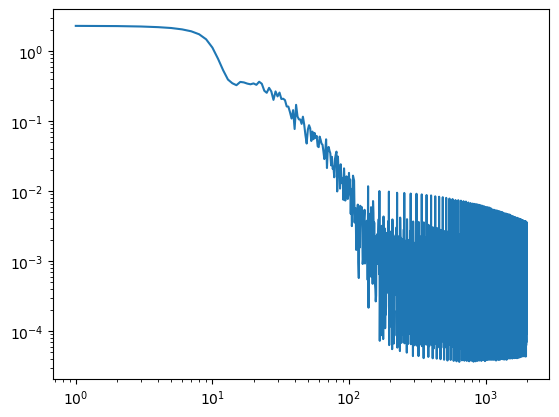

In [27]:
plt.plot(steps, losses)
plt.yscale('log')
plt.xscale('log')
plt.show()



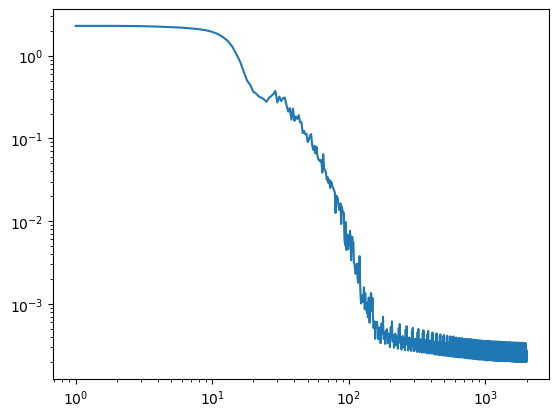

In [290]:
plt.plot(steps, losses)
plt.yscale('log')
plt.xscale('log')
plt.show()



In [29]:
reload_module()

lr_sm = [1e-5, 3e-5, 5e-5, 8e-5, 1e-4, 3e-4, 5e-4, 8e-4, 1e-3, 3e-3, 5e-3, 8e-3]
lr_lg = [1e-2, 3e-2, 5e-2, 8e-2, 1e-1, 3e-1, 5e-1, 8e-1, 1]
lrs = lr_sm + lr_lg

optims = sorted(OPTIM_MAP.keys())

print('''#! /bin/bash

set +e''')

seed = 0
for lr in lrs:
    for optim_kind in optims:
        # if 'sign' not in optim:
        #     continue
        file = f'241018_300steps_bzs2048/orth_{optim_kind}_lr{lr:g}_seed{seed}.pth'
        if os.path.exists(file):
            continue
        print(f"python /data/vision/phillipi/contrastive/tongzhou/qrl2/scripts/sbatch.py -g nvidia_h100_80gb_hbm3 nvidia_h100_nvl nvidia_a100-sxm4-80gb tesla_v100-sxm2-32gb -e py312 {optim_kind}_{lr:g} -- python -u 241018_muon_renorm.py {optim_kind} {lr:g} 0")
        # if os.path.exists(file + '.running'):
        #     with open(file + '.running', 'r') as f:
        #         line = f.readline().strip()
        #         if line != '0':
        #             raise ValueError(f'{file} is not done')
        #     continue


#! /bin/bash

set +e
python /data/vision/phillipi/contrastive/tongzhou/qrl2/scripts/sbatch.py -g nvidia_h100_80gb_hbm3 nvidia_h100_nvl nvidia_a100-sxm4-80gb tesla_v100-sxm2-32gb -e py312 muon_norm_fro_exact_target_momentum_dual_5e-05 -- python 241018_muon_renorm.py muon_norm_fro_exact_target_momentum_dual 5e-05 0
python /data/vision/phillipi/contrastive/tongzhou/qrl2/scripts/sbatch.py -g nvidia_h100_80gb_hbm3 nvidia_h100_nvl nvidia_a100-sxm4-80gb tesla_v100-sxm2-32gb -e py312 muon_norm_fro_target_glbavgmomentum_dual_5e-05 -- python 241018_muon_renorm.py muon_norm_fro_target_glbavgmomentum_dual 5e-05 0
python /data/vision/phillipi/contrastive/tongzhou/qrl2/scripts/sbatch.py -g nvidia_h100_80gb_hbm3 nvidia_h100_nvl nvidia_a100-sxm4-80gb tesla_v100-sxm2-32gb -e py312 muon_norm_fro_target_momentum_dual_5e-05 -- python 241018_muon_renorm.py muon_norm_fro_target_momentum_dual 5e-05 0
python /data/vision/phillipi/contrastive/tongzhou/qrl2/scripts/sbatch.py -g nvidia_h100_80gb_hbm3 nvidia_h100

In [110]:
model.load_state_dict(broken_sd)
data, target = data_target
with torch.no_grad():
    output = model(data.flatten(1))
    loss = F.cross_entropy(output, target)
print(f'Loss: {loss.item():.4f}')


Loss: 0.3066


In [111]:
# make model functional function of input and state dict
def func_call(param, input):
    return torch.func.functional_call(model, param, input)

bfunc_call = torch.vmap(func_call, in_dims=(-1, None), out_dims=(0,))


In [112]:
ws = torch.linspace(-1.5, 1.5, 500).to(torch.bfloat16).cuda()
interp_sd = {
    k: torch.lerp(pre_broken_sd[k][..., None], broken_sd[k][..., None], ws) for k in pre_broken_sd.keys()
}


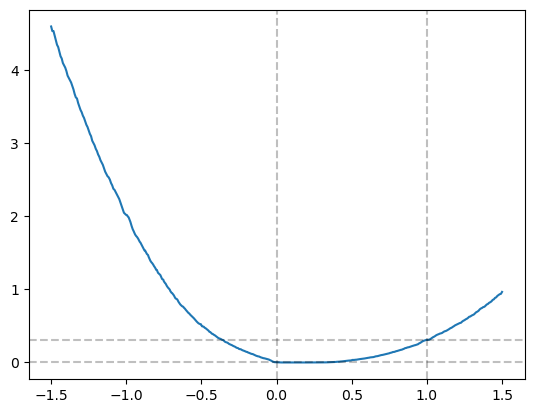

In [115]:
interp_losses = F.cross_entropy(bfunc_call(interp_sd, data.flatten(1)).flatten(0, 1), target.expand(ws.shape[0], -1).flatten(0, 1), reduction='none').unflatten(0, (ws.shape[0], -1)).mean(-1).cpu().data.to(torch.float32)

plt.plot(
    ws.cpu().data.to(torch.float32),
    interp_losses,
)
plt.axvline(0, c='k', ls='--', alpha=0.25)
plt.axhline(loss.item(), c='k', ls='--', alpha=0.25)
plt.axhline(0, c='k', ls='--', alpha=0.25)
plt.axvline(1, c='k', ls='--', alpha=0.25)
plt.show()


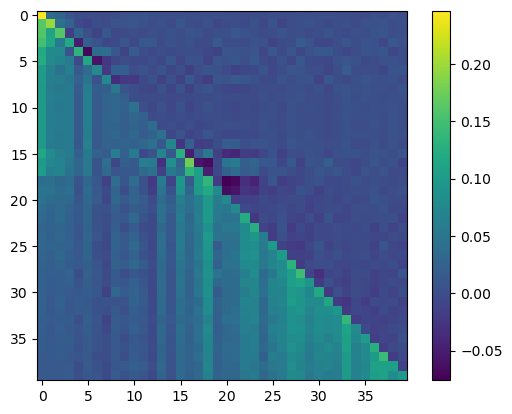

In [19]:
plt.imshow(F.cosine_similarity(updates[0:40].flatten(-2, -1)[:, None, :], grads[0:40].flatten(-2, -1)[None, :, :], dim=-1).cpu().data, interpolation='nearest')
plt.colorbar()
plt.show()



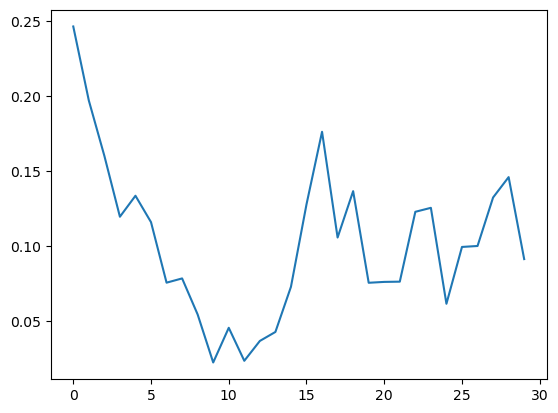

In [23]:
plt.plot(F.cosine_similarity(updates[:30].flatten(-2, -1), grads[:30].flatten(-2, -1), dim=-1).cpu().data)
plt.show()





In [138]:
import glob

for file in sorted(glob.glob('241018_300steps_bzs2048/orth*.running')):
    print(file)
    # os.rename(file, file.replace('muon_norm_fro_target', 'muon_norm_fro_exact_target'))

: 

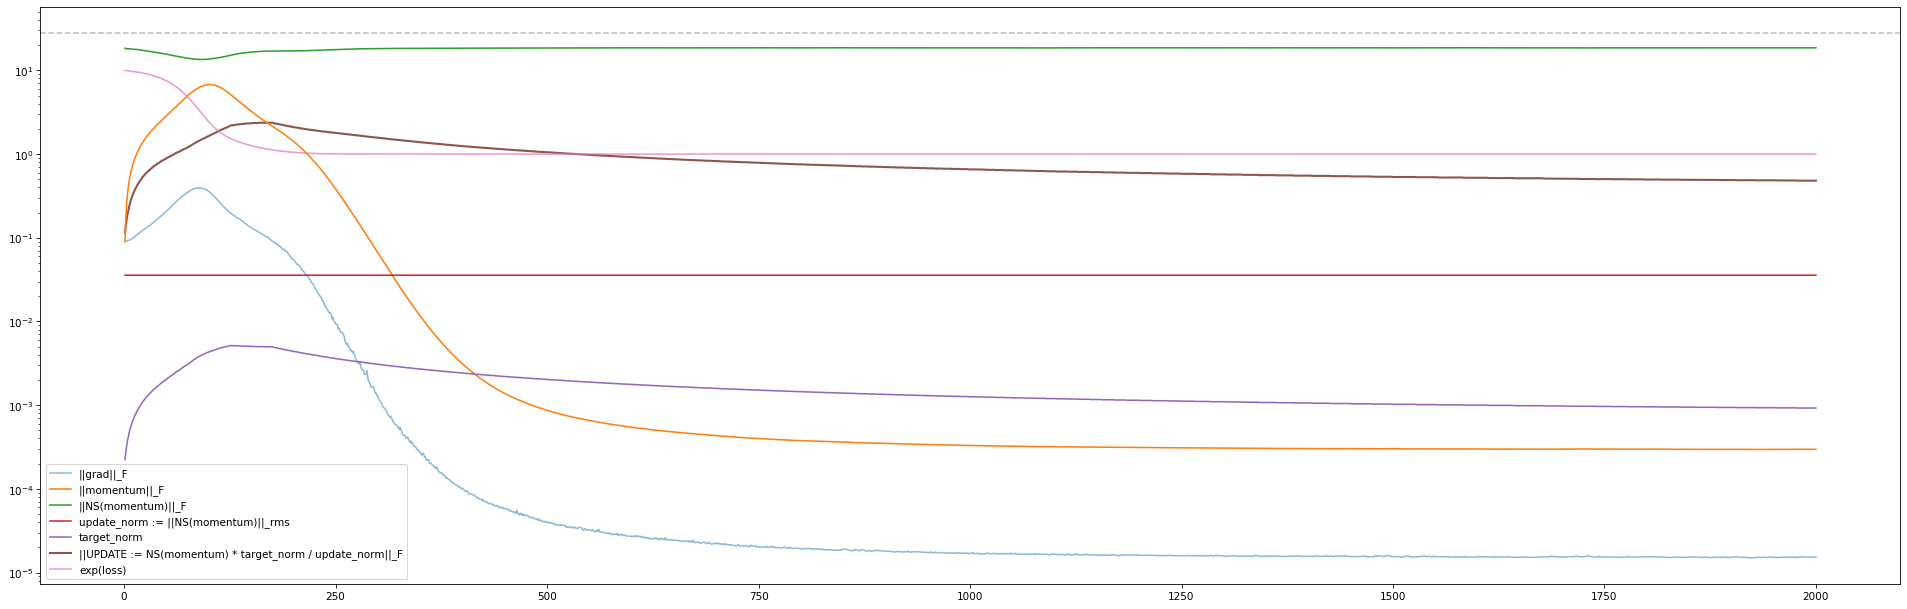

In [133]:
f, ax = plt.subplots(figsize=(32, 10), dpi=75)
plt.plot(steps, (grads.flatten(-2, -1).norm(dim=-1)).cpu().data, label='||grad||_F', alpha=0.5)
plt.plot(steps, (momentums.flatten(-2, -1).norm(dim=-1)).cpu().data, label='||momentum||_F', zorder=100)
plt.plot(steps, (updates.flatten(-2, -1).norm(dim=-1)).cpu().data, label='||NS(momentum)||_F')
plt.plot(steps, (gnorms).cpu().data, label='update_norm := ||NS(momentum)||_rms', zorder=100)
plt.plot(steps, (target_norms).cpu().data, label='target_norm', zorder=100)
plt.plot(steps, (target_norms / gnorms * updates.flatten(-2, -1).norm(dim=-1)).cpu().data, label='||UPDATE := NS(momentum) * target_norm / update_norm||_F', lw=2)
# plt.plot(steps, (momentum_0thpowers.flatten(-2, -1).norm(dim=-1)).cpu().data, label='momentum_0thpower norm')
plt.axhline(min(grads.shape[-2:]) ** 0.5, c='k', ls='--', alpha=0.25, zorder=100)
plt.plot(steps, torch.as_tensor(losses).exp().cpu().data, label='exp(loss)', alpha=0.75)
plt.yscale('log')
# plt.xscale('log')
# cap ylim to be no smaller than 1e-6 and no larger than 1e12
ymin, ymax = plt.ylim()
plt.ylim(max(ymin, 1e-12), min(ymax, 1e6))
# plt.xlim(0, 30)
plt.legend()
plt.show()